## NeurIPS heads replication

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-02 17:44:35.433110: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 17:44:36.700897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 17:44:37.174252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 17:44:37.175562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 3.1%
RAM Usage: 5.8%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [7]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset


In [8]:
# Load data
print("Loading data...")
X, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate', return_valid_genes=True)
Y = load_connectome(dataset='UKBB', parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

Loading data...


Build network dataloaders

In [9]:
# Create pairwise datasets for each subnetwork
unique_networks = np.unique(network_labels)
network_datasets = {}
network_dataloaders = {}
print("Creating pairwise datasets and dataloaders for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels == network
    
    # Subset data for this network
    X_network = X_valid[network_mask]
    Y_network = Y_valid[network_mask][:, network_mask]
    coords_network = coords_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping[idx] for i, idx in enumerate(network_indices)}
    
    # Create pairwise dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network,
        coords=coords_network,
        valid2true_mapping=network2true_mapping,
        dataset='UKBB',
        parcellation='S456', 
        valid_genes=valid_genes
    )
    
    # Create dataloader for this network
    network_dataloaders[network] = DataLoader(
        network_datasets[network],
        batch_size=512,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")


Creating pairwise datasets and dataloaders for each subnetwork...
Network Cerebellum: 72 region pairs
Network Cont: 2652 region pairs
Network Default: 8190 region pairs
Network DorsAttn: 2070 region pairs
Network Limbic: 650 region pairs
Network SalVentAttn: 2162 region pairs
Network SomMot: 5852 region pairs
Network Subcortical: 2070 region pairs
Network Vis: 3660 region pairs


Build full dataset

In [ ]:
# Create full pairwise dataset
print("Creating full pairwise dataset...")

# Create full pairwise dataset
full_dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid, 
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping,
    dataset='UKBB',
    parcellation='S456', 
    valid_genes=valid_genes
)

print(f"Full dataset: {len(full_dataset)} region pairs")

# Create full dataloader
full_dataloader = DataLoader(
    full_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Creating full pairwise dataset...
Full dataset: 206570 region pairs


Load in model trained on full UKBB dataset

In [12]:
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# SMT EMBEDDINGS - 3 versions ###
smt_model_v1 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v2 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v3 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare models
for i, model in enumerate([smt_model_v1, smt_model_v2, smt_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

# SMT CLS EMBEDDINGS - 3 versions ###
smt_cls_model_v1 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v2 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v3 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

# Load weights and prepare models
for i, model in enumerate([smt_cls_model_v1, smt_cls_model_v2, smt_cls_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smtcls_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

  warnings.warn(



Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067


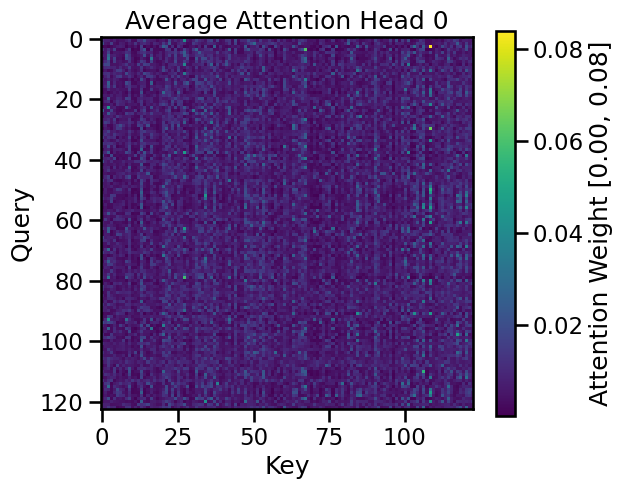

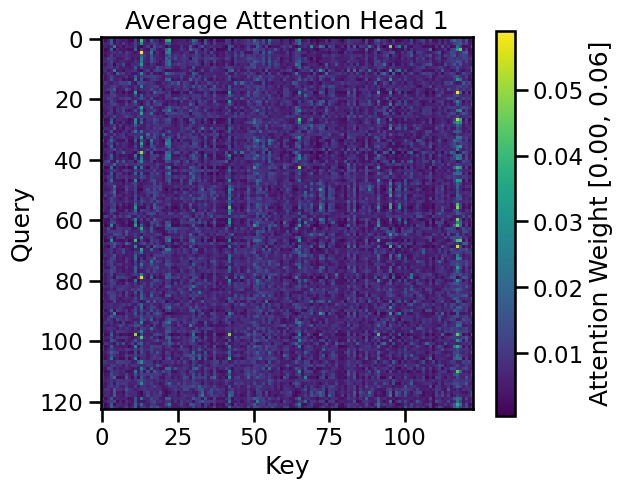

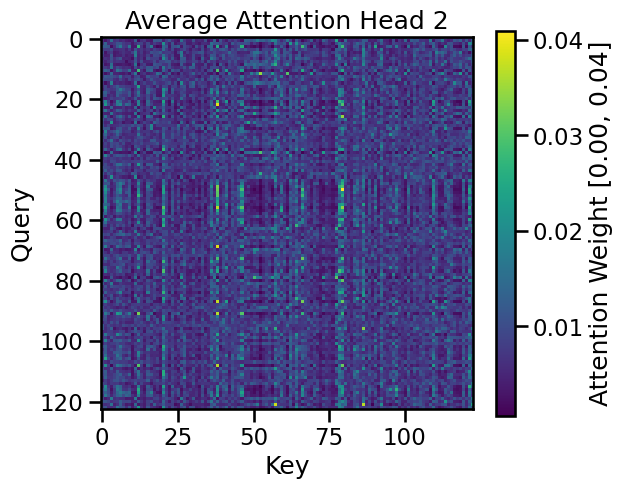

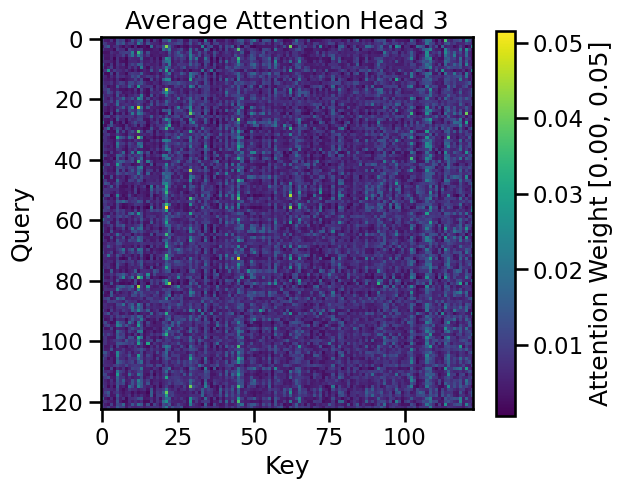

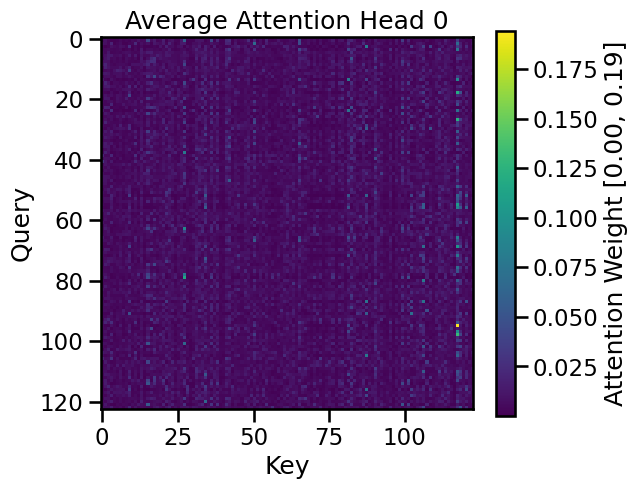

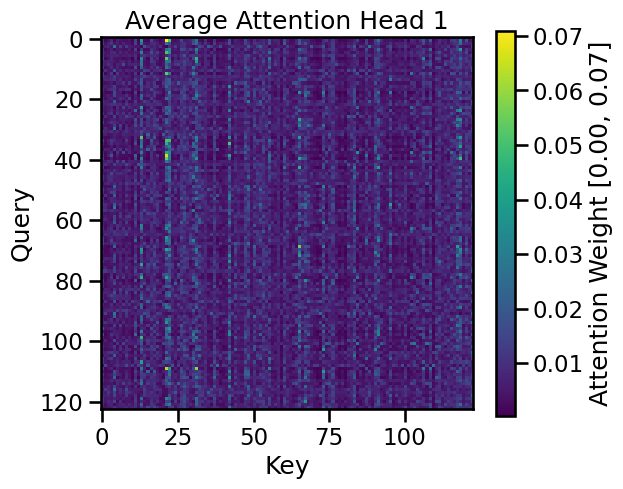

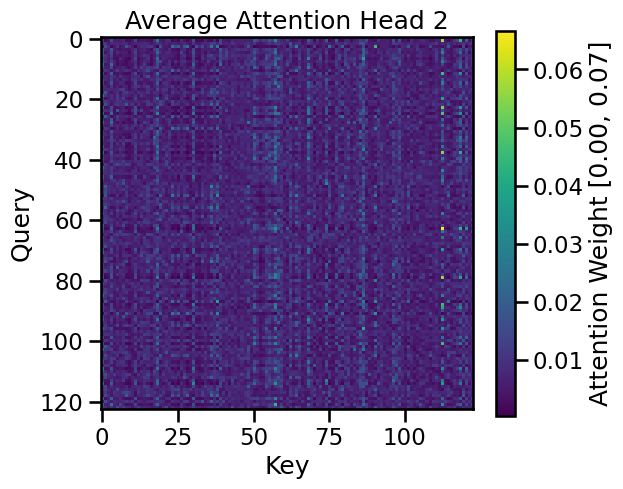

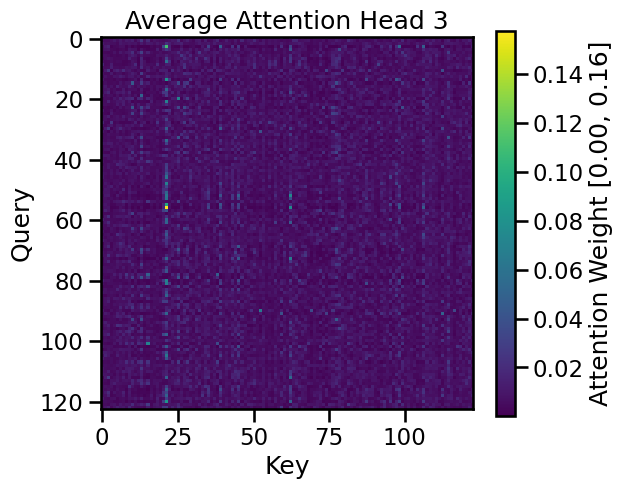

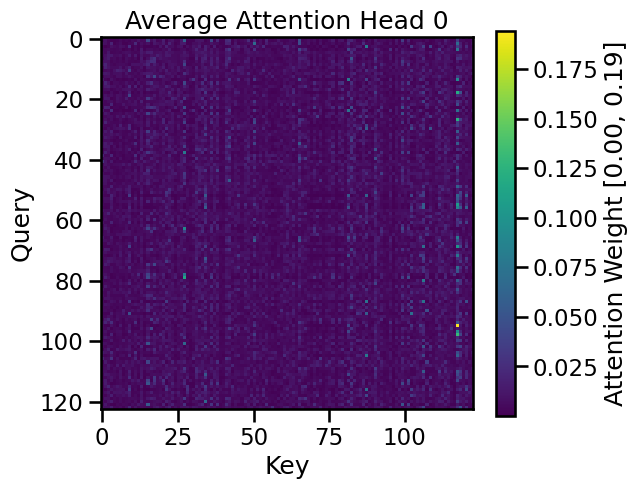

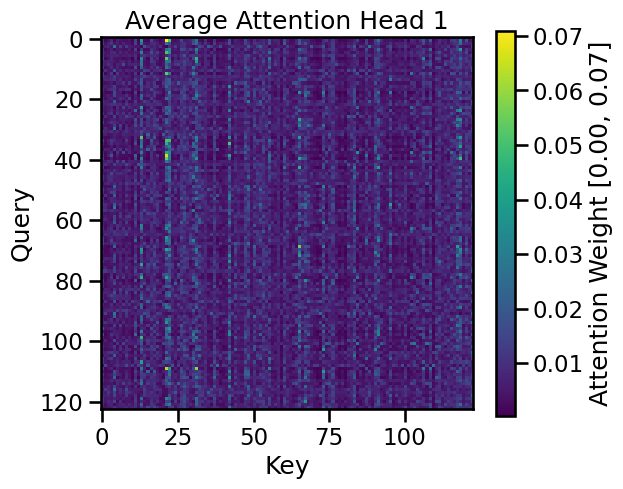

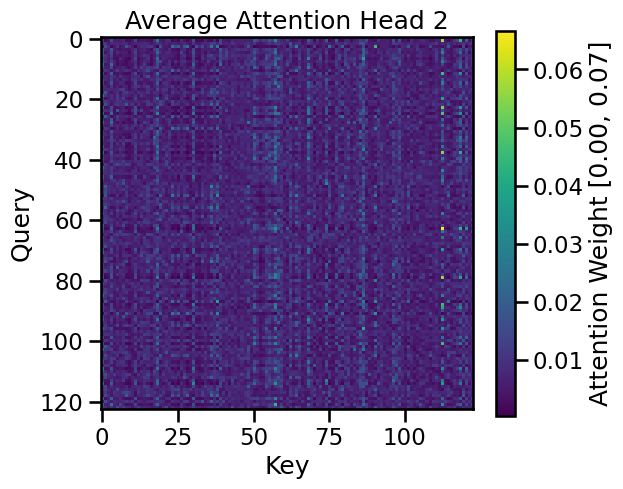

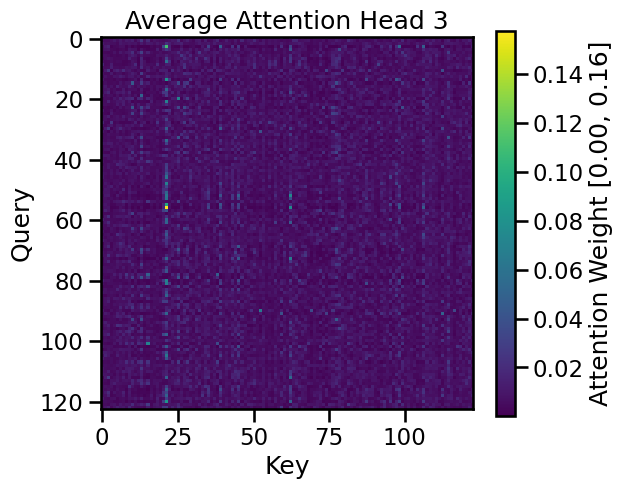

In [27]:
# Get predictions and attention weights for all 3 base SMT models on visual system data
print("Collecting attention weights for base SMT models on visual system data...")
subnetwork = 'Subcortical'
# Collect attention weights for each model
predictions_v1, targets_v1, avg_attn_v1 = smt_model_v1.predict(
    network_dataloaders[subnetwork],
    collect_attn=True
)

predictions_v2, targets_v2, avg_attn_v2 = smt_model_v2.predict(
    network_dataloaders[subnetwork], 
    collect_attn=True
)

predictions_v3, targets_v3, avg_attn_v3 = smt_model_v3.predict(
    network_dataloaders[subnetwork],
    collect_attn=True
)

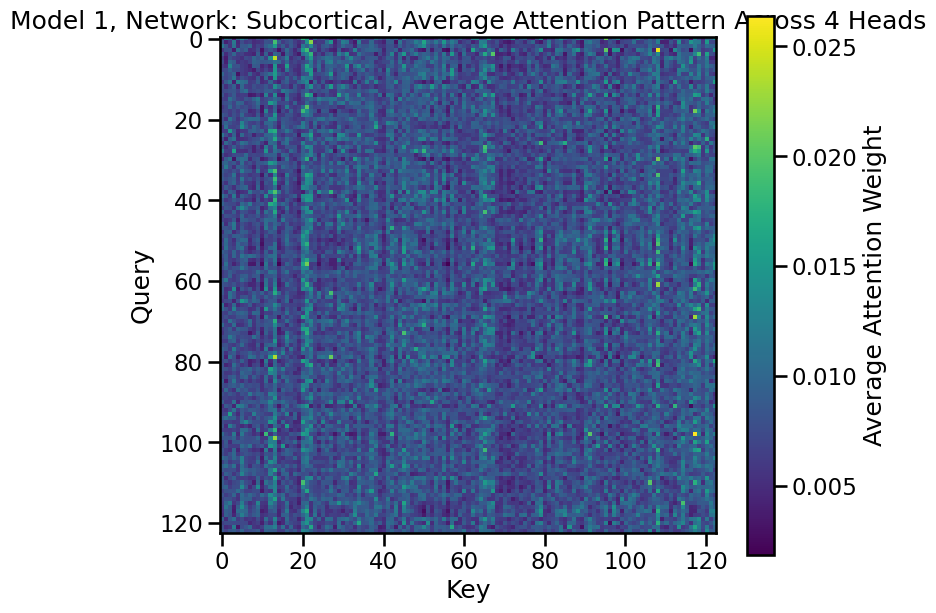

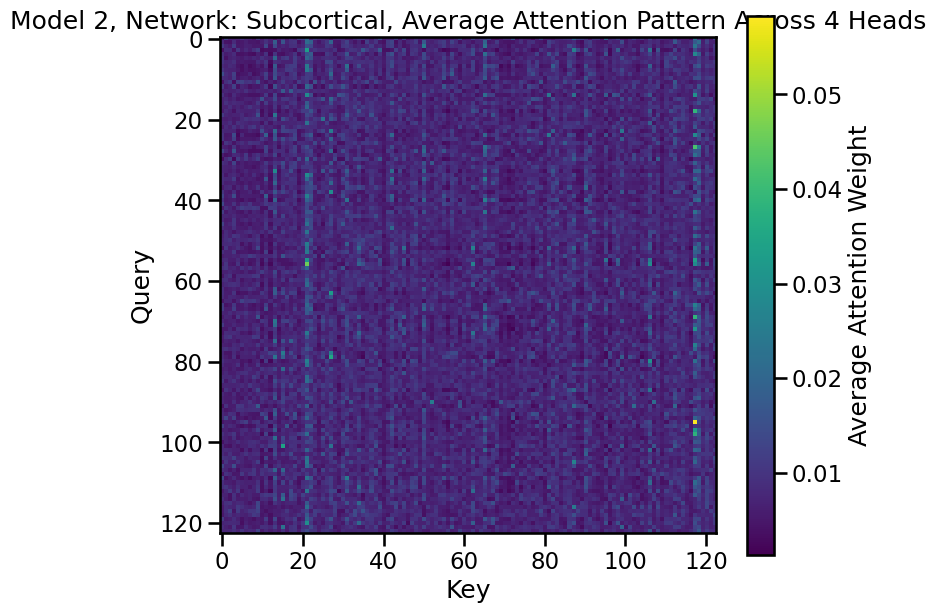

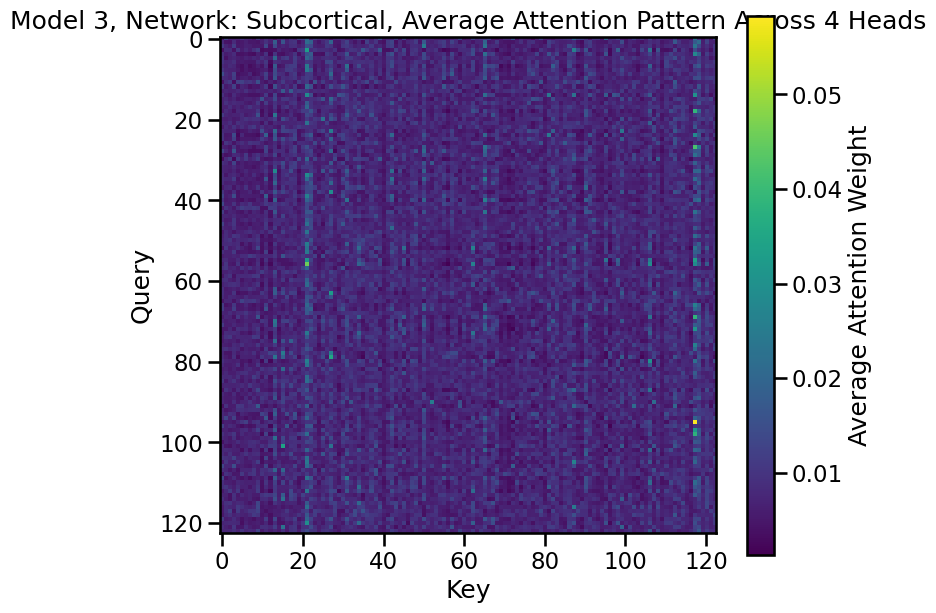

In [28]:
# Plot average attention pattern for each model
for i, avg_attn in enumerate([avg_attn_v1, avg_attn_v2, avg_attn_v3], 1):
    avg_attn_heads = avg_attn.mean(axis=0)
    plt.figure(figsize=(8, 7))
    plt.imshow(avg_attn_heads, cmap='viridis')
    plt.colorbar(label='Average Attention Weight')
    plt.title(f'Model {i}, Network: {subnetwork}, Average Attention Pattern Across 4 Heads')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.show()

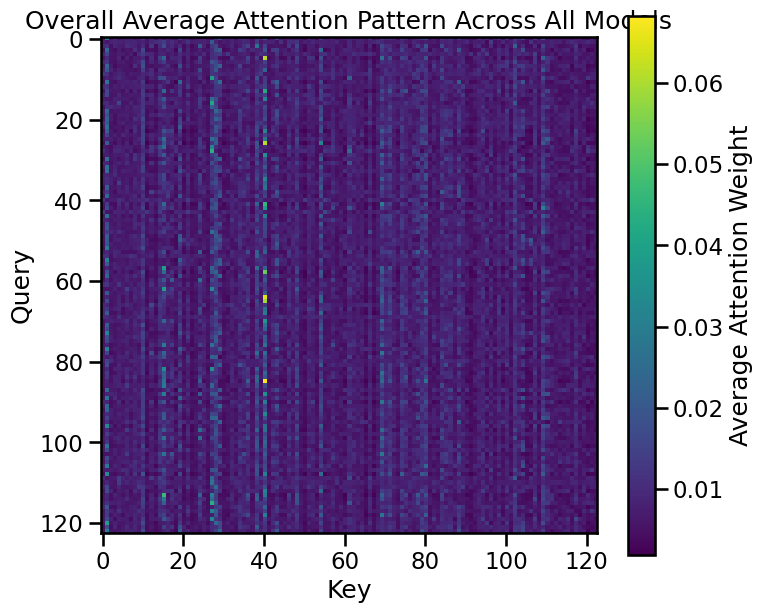

In [23]:
# Calculate and plot overall average across all models
overall_avg = (avg_attn_v1.mean(axis=0) + avg_attn_v2.mean(axis=0) + avg_attn_v3.mean(axis=0)) / 3
plt.figure(figsize=(8, 7))
plt.imshow(overall_avg, cmap='viridis')
plt.colorbar(label='Average Attention Weight')
plt.title('Overall Average Attention Pattern Across All Models')
plt.xlabel('Key')
plt.ylabel('Query')
plt.show()

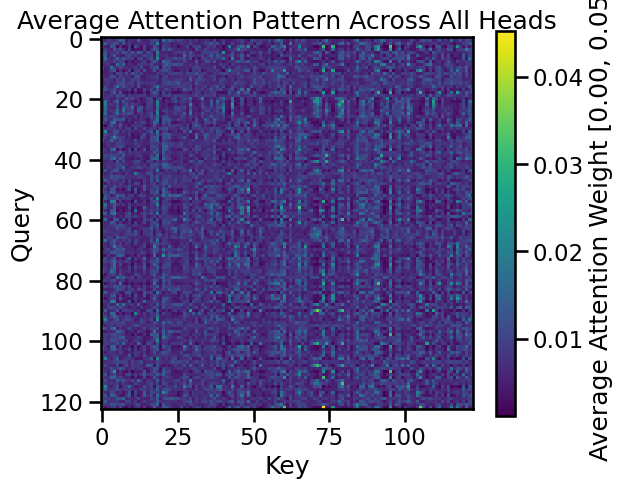

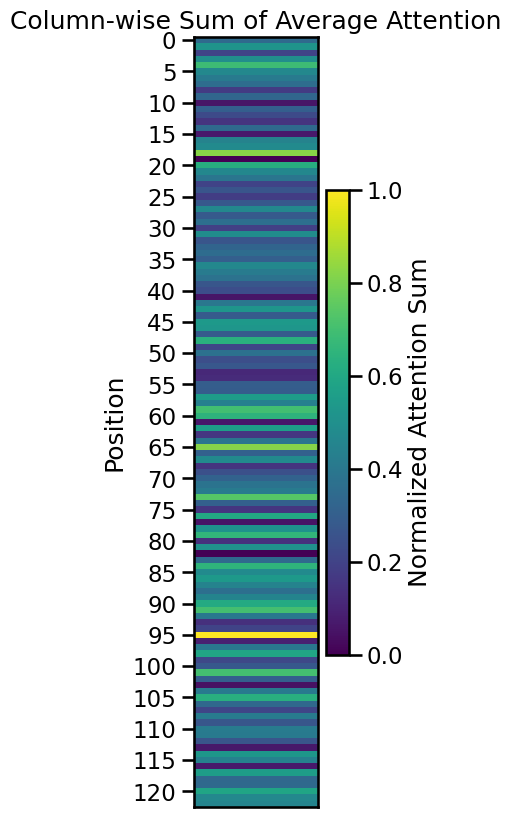

In [23]:
# Average attention weights across heads and plot
avg_attn_base_mean = avg_attn_base.mean(axis=0)

# Plot full attention matrix
plt.figure(figsize=(6, 5))
vmin, vmax = avg_attn_base_mean.min(), avg_attn_base_mean.max()
plt.imshow(avg_attn_base_mean, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(label=f"Average Attention Weight [{vmin:.2f}, {vmax:.2f}]")
plt.title("Average Attention Pattern Across All Heads")
plt.xlabel("Key") 
plt.ylabel("Query")
plt.show()

# Sum columns and plot as Nx1 matrix
attn_col_sums = avg_attn_base_mean.sum(axis=0)
attn_col_sums = (attn_col_sums - attn_col_sums.min()) / (attn_col_sums.max() - attn_col_sums.min())
plt.figure(figsize=(2, 10))
plt.imshow(attn_col_sums.reshape(-1, 1), cmap="viridis", aspect='auto')
plt.colorbar(label="Normalized Attention Sum")
plt.title("Column-wise Sum of Average Attention")
plt.ylabel("Position")
plt.xticks([])
plt.yticks(np.arange(0, len(attn_col_sums), 5))
plt.show()


In [ ]:

# Get predictions and attention weights for CLS SMT model  
print("\nCollecting attention weights for CLS SMT model...")
predictions_cls, targets_cls, avg_attn_cls = smt_cls_model.predict(
    full_dataloader, 
    collect_attn=True,
    save_attn_path='attn_cls_SMT_full_validation.npy'
)



In [10]:
network_dataloaders

{'Cerebellum': <torch.utils.data.dataloader.DataLoader at 0x7faa2d472990>,
 'Cont': <torch.utils.data.dataloader.DataLoader at 0x7faa1666dc10>,
 'Default': <torch.utils.data.dataloader.DataLoader at 0x7faa1666f390>,
 'DorsAttn': <torch.utils.data.dataloader.DataLoader at 0x7faa19d1c9d0>,
 'Limbic': <torch.utils.data.dataloader.DataLoader at 0x7faa15c1d1d0>,
 'SalVentAttn': <torch.utils.data.dataloader.DataLoader at 0x7faa1a287890>,
 'SomMot': <torch.utils.data.dataloader.DataLoader at 0x7faa103ad5d0>,
 'Subcortical': <torch.utils.data.dataloader.DataLoader at 0x7faa103ae850>,
 'Vis': <torch.utils.data.dataloader.DataLoader at 0x7faa103af9d0>}

In [9]:
# # Collect attention for each subnetwork
network_info = {
    0: ('Cerebellum', 72),
    1: ('Cont', 2652), 
    2: ('Default', 8190),
    3: ('DorsAttn', 2070),
    4: ('Limbic', 650),
    5: ('SalVentAttn', 2162),
    6: ('SomMot', 5852),
    7: ('Subcortical', 2070),
    8: ('Vis', 3660)
}

In [66]:
saved = True

if saved != True: 
    for i in range(9):
        network_name, num_pairs = network_info[i]
        print(f'Processing {network_name} network ({num_pairs} region pairs)')
        
        predictions_base_sub, targets_base_sub = smt_base_model.predict(
            network_dataloaders[network_name],
            collect_attn=True,
            save_attn_path=f'attn_base_SMT_full_training_{network_name}.npy'
        )
        
        predictions_cls_sub, targets_cls_sub = smt_cls_model.predict(
            network_dataloaders[network_name],
            collect_attn=True, 
            save_attn_path=f'attn_cls_SMT_full_training_{network_name}.npy'
        )    

Evaluate attention heads

In [67]:
def create_gene_tokens(token_chunk_size=20):
    """
    Create gene tokens and chromosome switch points based on token chunk size
    
    Args:
        token_chunk_size (int): Number of genes per token
        
    Returns:
        gene_tokens (list): List of dictionaries containing token info
        chrom_switches (list): List of indices where chromosomes switch
    """
    # Get valid genes from load_transcriptome
    from data.data_load import load_transcriptome

    X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', 
                                      run_PCA=False, omit_subcortical=False, hemisphere='both',
                                      impute_strategy='mirror_interpolate', sort_genes='refgenome', 
                                      return_valid_genes=True, null_model='none', random_seed=42)

    # Get reference genome info for valid genes
    refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

    valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
    
    # Create gene groups/tokens
    num_tokens = len(valid_refgenome) // token_chunk_size
    
    gene_tokens = []

    for i in range(num_tokens):
        start_idx = i * token_chunk_size
        end_idx = start_idx + token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:end_idx]
        
        # Get unique chromosome for this token
        chrom = token_genes['chromosome'].iloc[0]
        
        token = {
            'token_id': i,
            'genes': token_genes['gene_id'].tolist(),
            'chromosome': chrom
        }
        gene_tokens.append(token)

    # Handle remaining genes if any
    remaining_genes = len(valid_refgenome) % token_chunk_size
    if remaining_genes > 0:
        start_idx = num_tokens * token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:]
        token = {
            'token_id': num_tokens,
            'genes': token_genes['gene_id'].tolist(), 
            'chromosome': token_genes['chromosome'].iloc[0]
        }
        gene_tokens.append(token)
    # Get chromosome switch points
    chrom_switches = []
    for i in range(1, len(gene_tokens)):
        if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
            chrom_switches.append(i)
    
    # Print token and switch point info
    print(f"Number of tokens: {len(gene_tokens)}")
    print(f"Number of chromosome switch points: {len(chrom_switches)}")
    print("Example token:")
    print(gene_tokens[0])
    # Print chromosome switches to validate
    print("Chromosome switch points:")
    for i in chrom_switches:
        print(f"Switch at token {i}: {gene_tokens[i-1]['chromosome']} -> {gene_tokens[i]['chromosome']}")
    print('\n')
    return gene_tokens, chrom_switches

gene_tokens_20, chrom_switches_20 = create_gene_tokens(token_chunk_size=20)
gene_tokens_60, chrom_switches_60 = create_gene_tokens(token_chunk_size=60)

Number of tokens: 369
Number of chromosome switch points: 22
Example token:
{'token_id': 0, 'genes': ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10'], 'chromosome': 'NC_000001.11'}
Chromosome switch points:
Switch at token 37: NC_000001.11 -> NC_000002.12
Switch at token 62: NC_000002.12 -> NC_000003.12
Switch at token 84: NC_000003.12 -> NC_000004.12
Switch at token 99: NC_000004.12 -> NC_000005.10
Switch at token 118: NC_000005.10 -> NC_000006.12
Switch at token 137: NC_000006.12 -> NC_000007.14
Switch at token 154: NC_000007.14 -> NC_000008.11
Switch at token 168: NC_000008.11 -> NC_000009.12
Switch at token 182: NC_000009.12 -> NC_000010.11
Switch at token 198: NC_000010.11 -> NC_000011.10
Switch at token 219: NC_000011.10 -> NC_000012.12
Switch at token 239: NC_000012.12 -> NC_000013.11
Switch at token 246: NC_000013.11 -> NC_000014.9
Swi

In [68]:
network_info = {
    0: ('Cont', 2652), 
    1: ('SomMot', 5852),
    2: ('Default', 8190),
    3: ('DorsAttn', 2070),
    4: ('SalVentAttn', 2162),
    5: ('Vis', 3660),
    6: ('Limbic', 650),
    7: ('Cerebellum', 72),
    8: ('Subcortical', 2070)
}

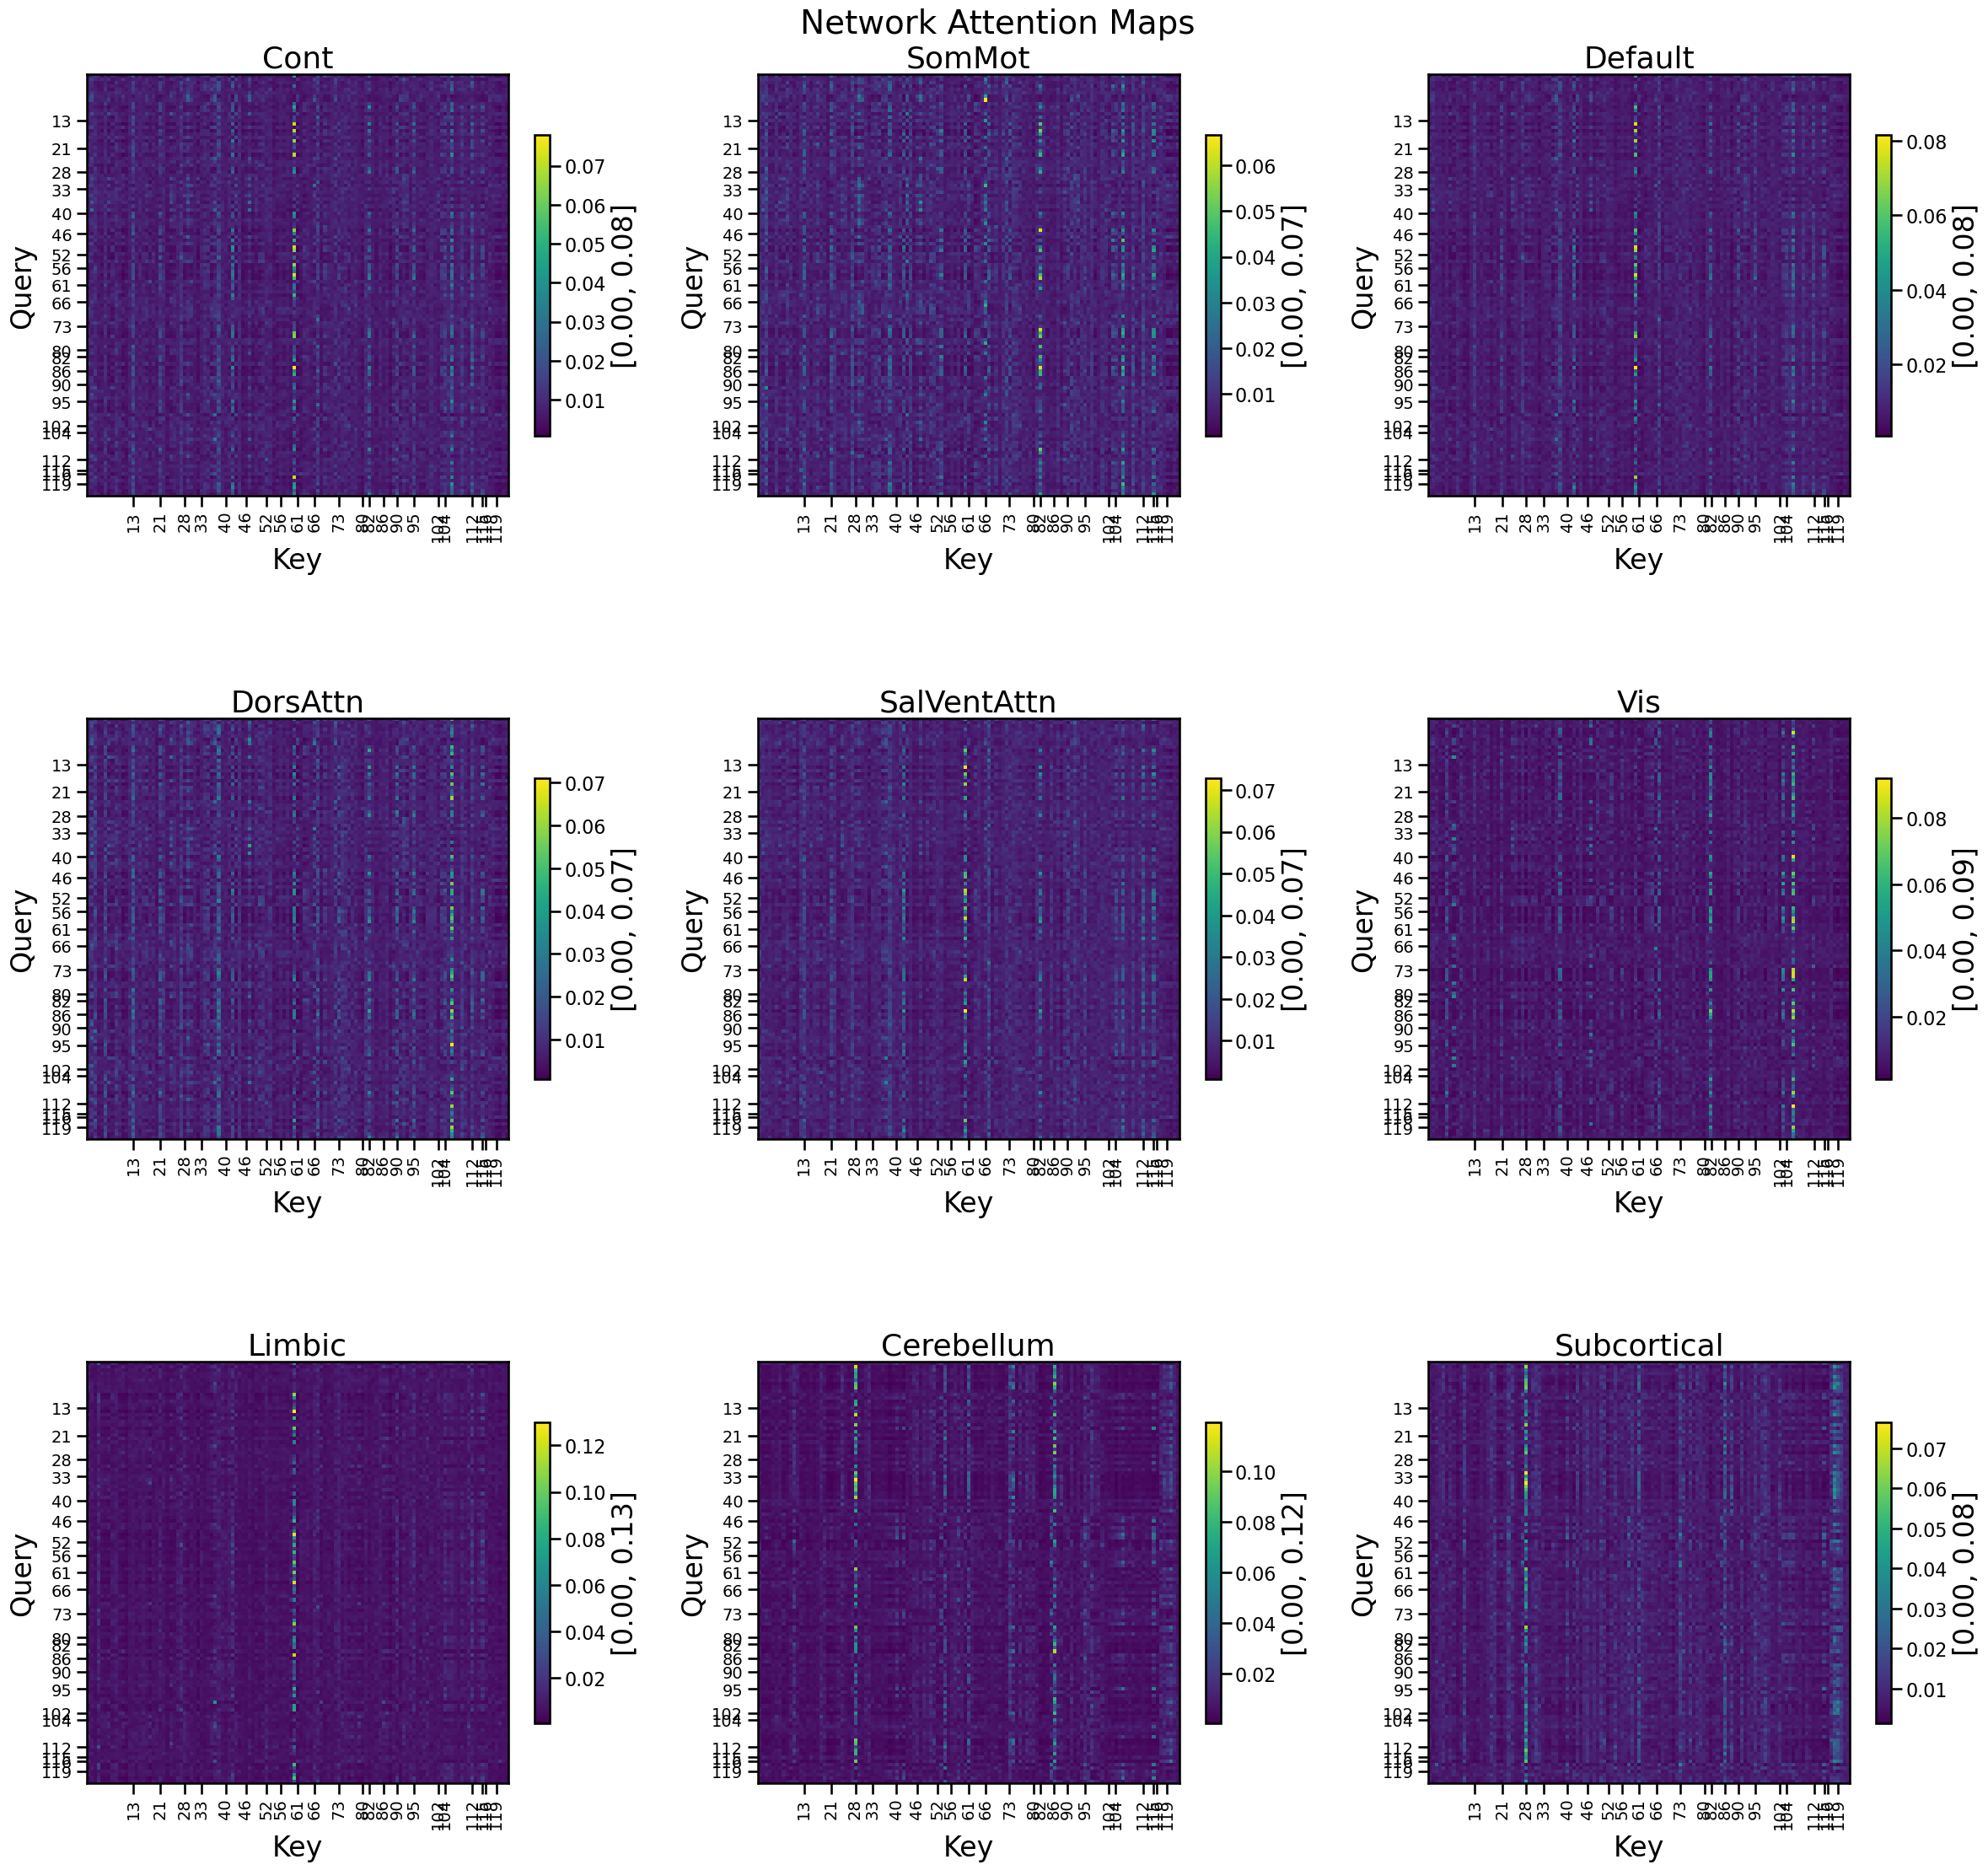

In [69]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24

def plot_network_head(avg_attn, chrom_switches, network_name, ax):
    '''
    Plot average attention weights for a specific network
    '''

    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    
    vmin, vmax = avg_head.min(), avg_head.max()
    im = ax.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.5)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    ax.set_title(f"{network_name}", fontsize=FONTSIZE+2)
    ax.set_xlabel("Key", fontsize=FONTSIZE)
    ax.set_ylabel("Query", fontsize=FONTSIZE)
    ax.set_xticks(chrom_switches)
    ax.set_yticks(chrom_switches)
    ax.tick_params(axis='both', labelsize=FONTSIZE-10)
    plt.setp(ax.get_xticklabels(), rotation=90)


# Create 3x3 subplot grid
fig = plt.figure(figsize=(24, 24))
fig.suptitle("Network Attention Maps", fontsize=FONTSIZE+4, y=0.95)

# Plot attention weights for each network
for i, (network_name, attn) in enumerate(network_attns.items()):
    ax = plt.subplot(3, 3, i+1)
    plot_network_head(attn, chrom_switches_60, network_name, ax)

plt.tight_layout()
plt.show()


In [70]:
network_info = {
    0: ('Vis', 3660),
    1: ('SomMot', 5852), 
    2: ('DorsAttn', 2070),
    3: ('SalVentAttn', 2162),
    4: ('Cont', 2652),
    5: ('Default', 8190),
    6: ('Limbic', 650),
    7: ('Subcortical', 2070),
    8: ('Cerebellum', 72)
}

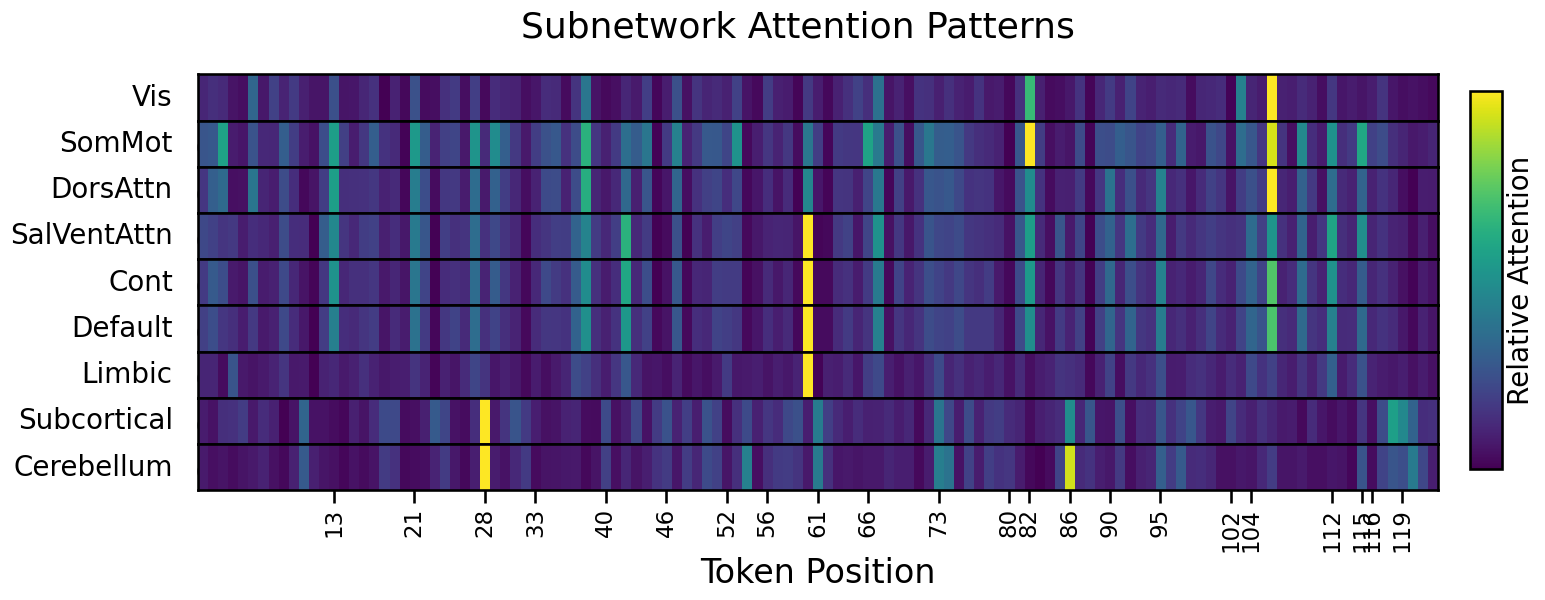

In [73]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24
def plot_network_attention_rows(network_attns, chrom_switches, chrom_ticks=False,smooth=False):
    '''
    Plot attention weights for all networks as rows in separate subplots
    '''
    # Get number of networks and tokens
    n_networks = len(network_attns)
    n_tokens = next(iter(network_attns.values())).shape[1]
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    fig.suptitle("Subnetwork Attention Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all attention values for normalization
    all_attention = np.zeros((n_networks, n_tokens))
    
    # First pass to get global min/max for normalization
    for i, (network_name, attn) in enumerate(network_attns.items()):
        avg_head = attn.mean(axis=0)
        row_data = np.sum(avg_head, axis=0)
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            row_data = gaussian_filter1d(row_data, sigma=.5)
        all_attention[i] = row_data
    
    # Process each network's attention into a separate subplot
    for i, (network_name, attn) in enumerate(network_attns.items()):
        row_data = all_attention[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            if chrom_ticks == False:
                axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
                axes[i].set_xticks(chrom_switches_60)
                axes[i].tick_params(axis='x', rotation=90)
            elif chrom_ticks:
                # Use chromosome numbers instead of token positions
                # Make sure we have same number of labels as tick positions
                chrom_labels = [str(i) for i in range(1,24)]  # Only 22 chromosomes to match ticks
                print(chrom_labels)
                axes[i].set_xlabel("Chromosome", fontsize=FONTSIZE)
                # Shift tick positions to start at 0
                tick_positions = [0] + list(chrom_switches_60)  # Convert numpy array slice to list
                axes[i].set_xticks(tick_positions)
                axes[i].set_xticklabels(chrom_labels)
                axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Relative Attention', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

    return all_attention

all_attention = plot_network_attention_rows(network_attns, chrom_switches_60, chrom_ticks=False)


In [90]:
# Calculate concentration of attention in top 3 tokens for each subnetwork
attention_concentration = {}

def analyze_attention_concentration(network_info, all_attention, n=3):
    attention_concentration = {}
    
    for i, (network_id, (network_name, _)) in enumerate(network_info.items()):
        # Get attention values for this network
        network_attn = all_attention[i]
        
        # Get indices and values of top n attention positions
        top_n_indices = np.argsort(network_attn)[-n:][::-1]
        top_n_values = network_attn[top_n_indices]
        
        # Calculate percentage of total attention in top n tokens
        total_attention = np.sum(network_attn)
        top_n_attention = np.sum(top_n_values)
        concentration = (top_n_attention / total_attention) * 100
        
        attention_concentration[network_name] = {
            f'top{n}_concentration': concentration,
            'token_positions': top_n_indices.tolist(),
            'attention_values': top_n_values.tolist()
        }
        
        print(f"{network_name}: {concentration:.1f}% of attention concentrated in top {n} tokens")
    
    return attention_concentration

attention_concentration = analyze_attention_concentration(network_info, all_attention, n=2)


Vis: 5.9% of attention concentrated in top 2 tokens
SomMot: 3.8% of attention concentrated in top 2 tokens
DorsAttn: 4.2% of attention concentrated in top 2 tokens
SalVentAttn: 3.8% of attention concentrated in top 2 tokens
Cont: 4.1% of attention concentrated in top 2 tokens
Default: 4.2% of attention concentrated in top 2 tokens
Limbic: 5.0% of attention concentrated in top 2 tokens
Subcortical: 4.8% of attention concentrated in top 2 tokens
Cerebellum: 6.9% of attention concentrated in top 2 tokens


In [89]:
# Find top 2 token positions with maximum attention for each subnetwork
max_attention_tokens = {}
def analyze_top_n_tokens(network_info, all_attention, gene_tokens_60, n=2):
    max_attention_tokens = {}
    
    for i, (network_id, (network_name, _)) in enumerate(network_info.items()):
        # Get attention values for this network
        network_attn = all_attention[i]
        
        # Get indices of top n max attention values
        top_n_indices = np.argsort(network_attn)[-n:][::-1]
        top_n_values = network_attn[top_n_indices]
        
        # Store results
        max_attention_tokens[network_name] = {
            'token_positions': top_n_indices.tolist(),
            'attention_values': top_n_values.tolist(),
            'genes': [gene_tokens_60[pos]['genes'] for pos in top_n_indices]
        }
        
        # Print network name and top token positions in order of importance
        token_str = ', '.join([f"Token {idx}" for idx in top_n_indices])
        print(f"{network_name}: {token_str}")
    
    return max_attention_tokens

max_attention_tokens = analyze_top_n_tokens(network_info, all_attention, gene_tokens_60, n=2)


Vis: Token 106, Token 82
SomMot: Token 82, Token 106
DorsAttn: Token 106, Token 38
SalVentAttn: Token 60, Token 42
Cont: Token 60, Token 106
Default: Token 60, Token 106
Limbic: Token 60, Token 112
Subcortical: Token 28, Token 118
Cerebellum: Token 28, Token 86


In [78]:
print(" ".join(gene_tokens_60[28]['genes']))
print('\n')
print(" ".join(gene_tokens_60[60]['genes']))
print(" ".join(gene_tokens_60[82]['genes']))
print(" ".join(gene_tokens_60[106]['genes']))

NSD2 NELFA NAT8L HAUS3 MXD4 ZFYVE28 ADD1 NOP14 MSANTD1 RGS12 DOK7 LRPAP1 ADRA2C FAM86EP NSG1 STX18 MSX1 CYTL1 CRMP1 JAKMIP1 WFS1 MRFAP1 LINC02482 TBC1D14 CCDC96 TADA2B SORCS2 ABLIM2 ACOX3 DEFB131A WDR1 HS3ST1 CPEB2 CD38 TAPT1 LDB2 QDPR DCAF16 SLIT2 ADGRA3 PPARGC1A LGI2 ANAPC4 SEL1L3 TBC1D19 STIM2 PCDH7 ARAP2 NWD2 RELL1 TBC1D1 PTTG2 FAM114A1 KLHL5 WDR19 RFC1 RPL9 LIAS SMIM14 UBE2K


SLC2A6 ADAMTSL2 FAM163B SARDH VAV2 RXRA COL5A1 OLFM1 PPP1R26 C9orf116 SOHLH1 KCNT1 NACC2 TMEM250 GPSM1 CARD9 PMPCA SEC16A EGFL7 SNHG7 LCN15 TMEM141 PHPT1 FBXW5 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 TMEM203 RNF208 TUBB4B NRARP EXD3 NSMF PNPLA7 EHMT1 TUBB8 ZMYND11 IDI2-AS1 IDI1 WDR37 ADARB2-AS1 PFKP PITRM1 LOC105376360 KLF6 AKR1C1 AKR1C3 AKR1C4 CALML3 ASB13 ANKRD16 PFKFB3 PRKCQ-AS1 SFMBT2 ITIH5 TAF3 CELF2 USP6NL ECHDC3
PNP RNASE6 METTL17 NDRG2 ARHGEF40 ZNF219 HNRNPC RAB2B TOX4 SALL2 DAD1 ABHD4 OXA1L SLC7A7 PRMT5 HAUS4 PSMB5 C14orf119 SLC7A8 HOMEZ PPP1R3E BCL2L2 MYH7 THTPA ZFHX2 AP1G2 JPH4 DHRS2 DHRS4 CARMIL3 CPNE6 PCK2

In [50]:
all_attention.shape

(9, 123)

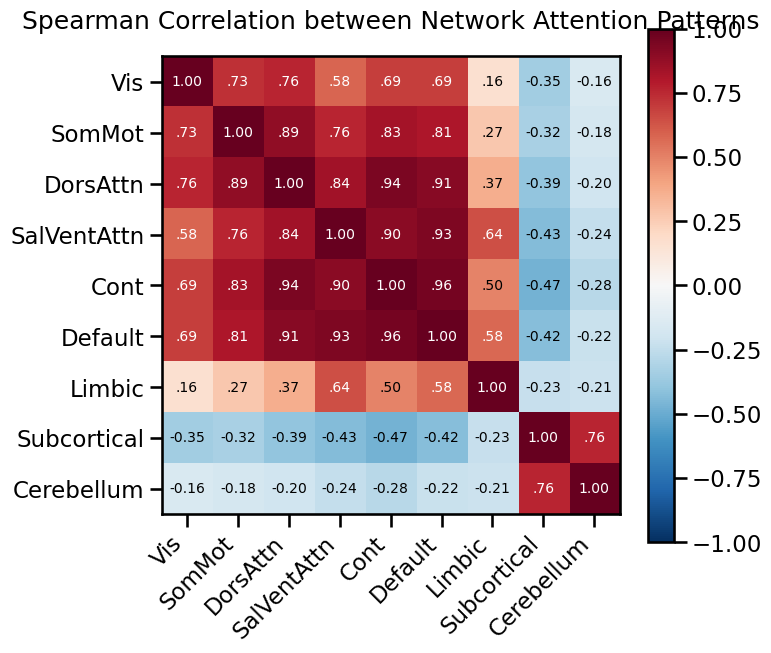

In [54]:
# Compute Spearman correlation between network attention patterns
import scipy.stats as stats

# Get network names in order from network_info
network_names = [info[0] for net, info in network_info.items()]

# Calculate correlation matrix
n_networks = len(network_names)
corr_matrix = np.zeros((n_networks, n_networks))

for i in range(n_networks):
    for j in range(n_networks):
        corr, _ = stats.spearmanr(all_attention[i], all_attention[j])
        corr_matrix[i,j] = corr

# Create figure
plt.figure(figsize=(8,7))

# Plot heatmap
im = plt.imshow(corr_matrix,
                cmap='RdBu_r', 
                vmin=-1, vmax=1,
                aspect='equal')

# Add colorbar
plt.colorbar(im)

# Add text annotations
for i in range(n_networks):
    for j in range(n_networks):
        text = f'{corr_matrix[i,j]:.2f}'.lstrip('0')  # Remove leading zeros
        plt.text(j, i, text,
                ha='center', va='center',
                color='black' if abs(corr_matrix[i,j]) < 0.5 else 'white',
                fontsize=10)  # Make text smaller

# Set ticks and labels
plt.xticks(range(n_networks), network_names, rotation=45, ha='right')
plt.yticks(range(n_networks), network_names)

plt.title('Spearman Correlation between Network Attention Patterns', pad=20)

# Adjust layout
plt.tight_layout()
plt.show()


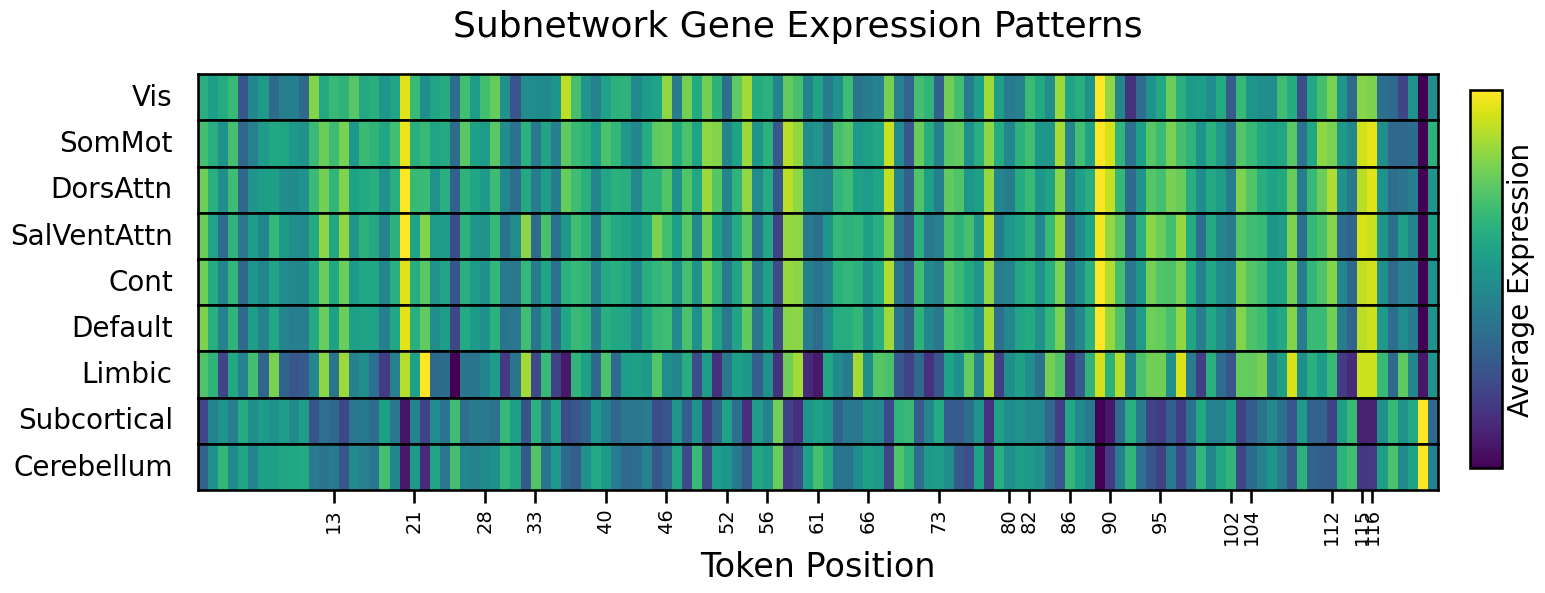

In [60]:
# Load gene expression data and network labels
network_expr = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    # Get indices for this network
    network_mask = network_labels == network_name
    # Get expression data for nodes in this network
    network_expr[network_name] = X_valid[network_mask]

# Global font size parameter  
FONTSIZE = 24

def plot_network_expression_rows(network_expr, chrom_switches, token_dim=60, chrom_ticks=False, smooth=True):
    '''
    Plot average gene expression for all networks as rows in separate subplots,
    with genes grouped into chunks of token_dim size
    '''
    chrom_switches = chrom_switches[:-1]

    # Get number of networks and genes
    n_networks = len(network_expr)
    n_genes = X_valid.shape[1]
    
    # Calculate number of tokens based on gene chunks of token_dim size
    n_tokens = (n_genes + token_dim - 1) // token_dim  # Ceiling division
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    fig.suptitle("Subnetwork Gene Expression Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all binned expression values
    all_expression = np.zeros((n_networks, n_tokens))
    
    # First pass to get binned expression values
    for i, (network_name, expr) in enumerate(network_expr.items()):
        # Average expression across nodes in network
        network_avg = expr.mean(axis=0)
        
        # Bin the genes into token-sized chunks
        binned_expr = np.zeros(n_tokens)
        for j in range(n_tokens):
            start_idx = j * token_dim
            end_idx = min(start_idx + token_dim, n_genes)
            binned_expr[j] = network_avg[start_idx:end_idx].mean()
            
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            binned_expr = gaussian_filter1d(binned_expr, sigma=.5)
        all_expression[i] = binned_expr
    
    # Process each network's expression into a separate subplot
    for i, (network_name, expr) in enumerate(network_expr.items()):
        row_data = all_expression[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            if chrom_ticks == False:
                axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
                axes[i].set_xticks(chrom_switches)
            elif chrom_ticks:
                # Use chromosome numbers instead of token positions
                chrom_labels = [str(i) for i in range(1,24)]  # Only 22 chromosomes to match ticks
                axes[i].set_xlabel("Chromosome", fontsize=FONTSIZE)
                # Shift tick positions to start at 0
                tick_positions = [0] + list(chrom_switches)  # Convert numpy array slice to list
                axes[i].set_xticks(tick_positions)
                axes[i].set_xticklabels(chrom_labels)
            axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        else:
            axes[i].set_xticks([])
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Average Expression', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

    return all_expression

all_expression = plot_network_expression_rows(network_expr, chrom_switches_60, token_dim=60, chrom_ticks=False, smooth=False)


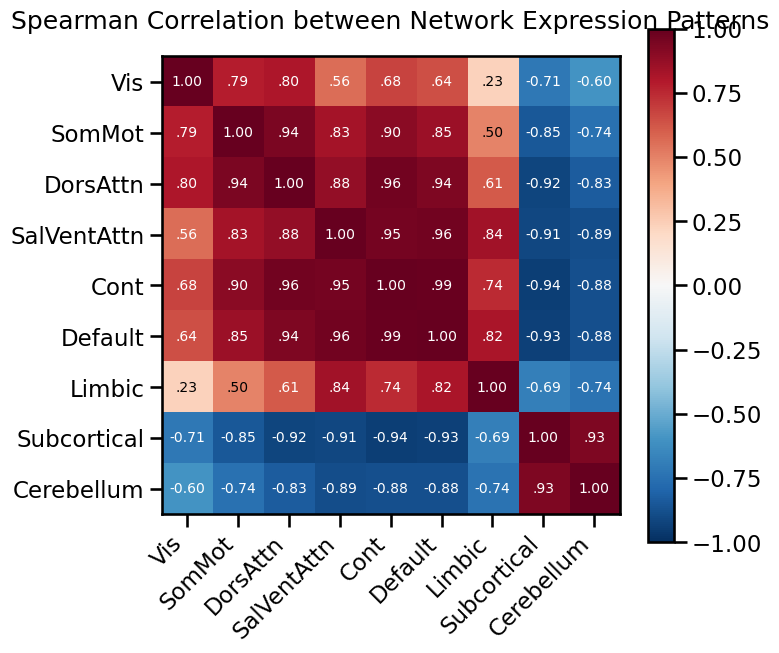

In [61]:
# Compute Spearman correlation between network expression patterns
import scipy.stats as stats

# Get network names in order from network_info
network_names = [info[0] for net, info in network_info.items()]

# Calculate correlation matrix
n_networks = len(network_names)
corr_matrix = np.zeros((n_networks, n_networks))

for i in range(n_networks):
    for j in range(n_networks):
        corr, _ = stats.spearmanr(all_expression[i], all_expression[j])
        corr_matrix[i,j] = corr

# Create figure
plt.figure(figsize=(8,7))

# Plot heatmap
im = plt.imshow(corr_matrix,
                cmap='RdBu_r', 
                vmin=-1, vmax=1,
                aspect='equal')

# Add colorbar
plt.colorbar(im)

# Add text annotations
for i in range(n_networks):
    for j in range(n_networks):
        text = f'{corr_matrix[i,j]:.2f}'.lstrip('0')  # Remove leading zeros
        plt.text(j, i, text,
                ha='center', va='center',
                color='black' if abs(corr_matrix[i,j]) < 0.5 else 'white',
                fontsize=10)  # Make text smaller

# Set ticks and labels
plt.xticks(range(n_networks), network_names, rotation=45, ha='right')
plt.yticks(range(n_networks), network_names)

plt.title('Spearman Correlation between Network Expression Patterns', pad=20)

# Adjust layout
plt.tight_layout()
plt.show()


Base Model Average Attention:


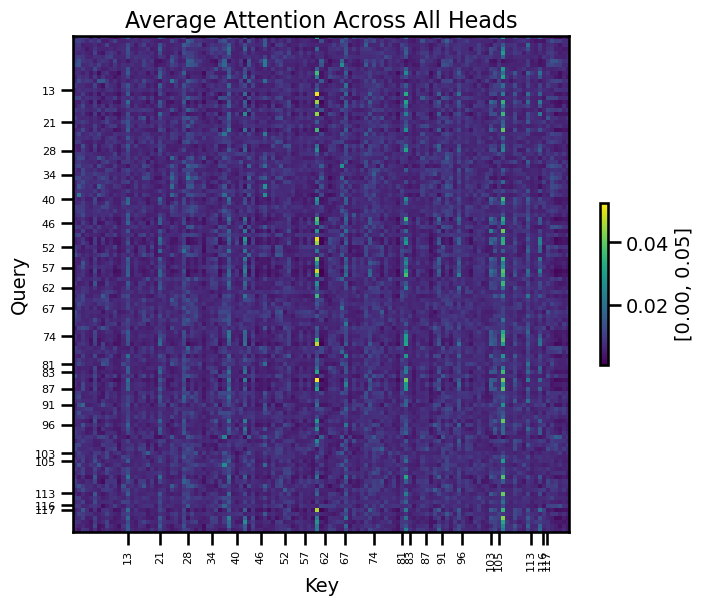

In [98]:
# Plot average attention heads separately
print("Base Model Average Attention:")
plot_average_head(avg_base_smt_attn, chrom_switches)


CLS Model Average Attention:


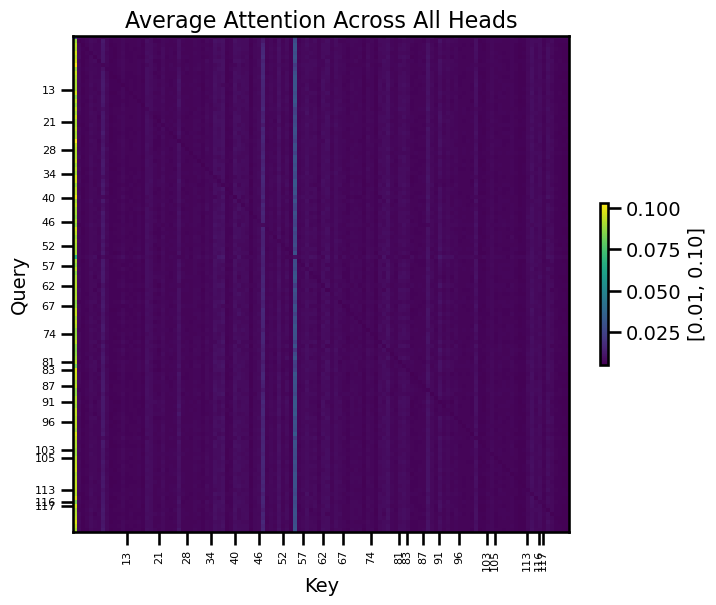


Genes in token:  54
['PKIA', 'ZC2HC1A', 'STMN2', 'HEY1', 'TPD52', 'ZBTB10', 'PAG1', 'FABP5', 'PMP2', 'IMPA1', 'E2F5', 'CA13', 'CA2', 'WWP1', 'RMDN1', 'CPNE3', 'MMP16', 'RIPK2', 'CALB1', 'NECAB1', 'PIP4P2', 'OTUD6B-AS1', 'OTUD6B', 'RUNX1T1', 'PDP1', 'GEM', 'RAD54B', 'FSBP', 'INTS8', 'MTERF3', 'SDC2', 'TSPYL5', 'MTDH', 'LAPTM4B', 'MATN2', 'RPL30', 'ERICH5', 'RIDA', 'NIPAL2', 'KCNS2', 'RGS22', 'POLR2K', 'PABPC1', 'YWHAZ', 'ZNF706', 'NCALD', 'RRM2B', 'UBR5', 'KLF10', 'GASAL1', 'AZIN1', 'AZIN1-AS1', 'ATP6V1C1', 'FZD6', 'SLC25A32', 'RIMS2', 'LRP12', 'ZFPM2', 'OXR1', 'ANGPT1']

Chromosome: NC_000008.11
PKIA ZC2HC1A STMN2 HEY1 TPD52 ZBTB10 PAG1 FABP5 PMP2 IMPA1 E2F5 CA13 CA2 WWP1 RMDN1 CPNE3 MMP16 RIPK2 CALB1 NECAB1 PIP4P2 OTUD6B-AS1 OTUD6B RUNX1T1 PDP1 GEM RAD54B FSBP INTS8 MTERF3 SDC2 TSPYL5 MTDH LAPTM4B MATN2 RPL30 ERICH5 RIDA NIPAL2 KCNS2 RGS22 POLR2K PABPC1 YWHAZ ZNF706 NCALD RRM2B UBR5 KLF10 GASAL1 AZIN1 AZIN1-AS1 ATP6V1C1 FZD6 SLC25A32 RIMS2 LRP12 ZFPM2 OXR1 ANGPT1


In [103]:
print("\nCLS Model Average Attention:") 
plot_average_head(avg_smt_cls_attn, chrom_switches)

true_token_num = 55 - 1
print("\nGenes in token: ", true_token_num)
print(gene_tokens[true_token_num]['genes'])
print("\nChromosome:", gene_tokens[true_token_num]['chromosome'])
print(' '.join(gene_tokens[true_token_num]['genes']))


In [108]:
true_token_num = 60
print("\nGenes in token: ", true_token_num)
print(gene_tokens[true_token_num]['genes'])
print("\nChromosome:", gene_tokens[true_token_num]['chromosome'])
print(' '.join(gene_tokens[true_token_num]['genes']))


Genes in token:  60
['GOLGA2', 'SWI5', 'URM1', 'TBC1D13', 'ENDOG', 'KYAT1', 'PHYHD1', 'SH3GLB2', 'PTPA', 'IER5L', 'LINC00963', 'NTMT1', 'ASB6', 'PTGES', 'NCS1', 'ASS1', 'FUBP3', 'FAM78A', 'PLPP7', 'PRRC2B', 'POMT1', 'NTNG2', 'DDX31', 'AK8', 'SURF1', 'SURF4', 'ADAMTS13', 'SLC2A6', 'ADAMTSL2', 'FAM163B', 'SARDH', 'VAV2', 'RXRA', 'COL5A1', 'OLFM1', 'PPP1R26', 'C9orf116', 'SOHLH1', 'KCNT1', 'NACC2', 'TMEM250', 'GPSM1', 'CARD9', 'PMPCA', 'SEC16A', 'EGFL7', 'SNHG7', 'LCN15', 'TMEM141', 'PHPT1', 'FBXW5', 'NPDC1', 'SAPCD2', 'MAN1B1-AS1', 'DPP7', 'TMEM203', 'RNF208', 'TUBB4B', 'NRARP', 'EXD3']

Chromosome: NC_000009.12
GOLGA2 SWI5 URM1 TBC1D13 ENDOG KYAT1 PHYHD1 SH3GLB2 PTPA IER5L LINC00963 NTMT1 ASB6 PTGES NCS1 ASS1 FUBP3 FAM78A PLPP7 PRRC2B POMT1 NTNG2 DDX31 AK8 SURF1 SURF4 ADAMTS13 SLC2A6 ADAMTSL2 FAM163B SARDH VAV2 RXRA COL5A1 OLFM1 PPP1R26 C9orf116 SOHLH1 KCNT1 NACC2 TMEM250 GPSM1 CARD9 PMPCA SEC16A EGFL7 SNHG7 LCN15 TMEM141 PHPT1 FBXW5 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 TMEM203 RNF208 TUBB4B N

valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

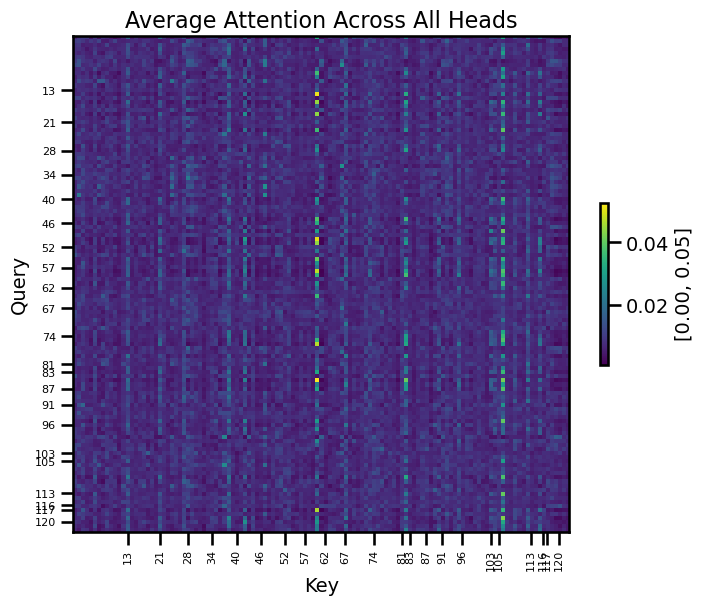


Genes in token 106:
['HSD11B1L', 'RPL36', 'LONP1', 'RFX2', 'MLLT1', 'KHSRP', 'SLC25A41', 'SLC25A23', 'DENND1C', 'C3', 'GPR108', 'VAV1', 'ZNF557', 'INSR', 'ARHGEF18', 'ZNF358', 'MCOLN1', 'CLEC4G', 'CLEC4M', 'TGFBR3L', 'CTXN1', 'TIMM44', 'ELAVL1', 'CERS4', 'KANK3', 'RAB11B', 'MYO1F', 'OR7E24', 'ZNF562', 'ZNF812P', 'FBXL12', 'UBL5', 'PIN1', 'OLFM2', 'COL5A3', 'C19orf66', 'S1PR2', 'MRPL4', 'ICAM5', 'FDX1L', 'ICAM3', 'CDC37', 'PDE4A', 'KEAP1', 'ATG4D', 'KRI1', 'CDKN2D', 'SLC44A2', 'LDLR', 'FH', 'RAB3D', 'TMEM205', 'PLPPR2', 'ELAVL3', 'ZNF653', 'ECSIT', 'CNN1', 'ELOF1', 'ZNF844', 'ZNF136']

Chromosome: NC_000019.10
HSD11B1L RPL36 LONP1 RFX2 MLLT1 KHSRP SLC25A41 SLC25A23 DENND1C C3 GPR108 VAV1 ZNF557 INSR ARHGEF18 ZNF358 MCOLN1 CLEC4G CLEC4M TGFBR3L CTXN1 TIMM44 ELAVL1 CERS4 KANK3 RAB11B MYO1F OR7E24 ZNF562 ZNF812P FBXL12 UBL5 PIN1 OLFM2 COL5A3 C19orf66 S1PR2 MRPL4 ICAM5 FDX1L ICAM3 CDC37 PDE4A KEAP1 ATG4D KRI1 CDKN2D SLC44A2 LDLR FH RAB3D TMEM205 PLPPR2 ELAVL3 ZNF653 ECSIT CNN1 ELOF1 ZNF844

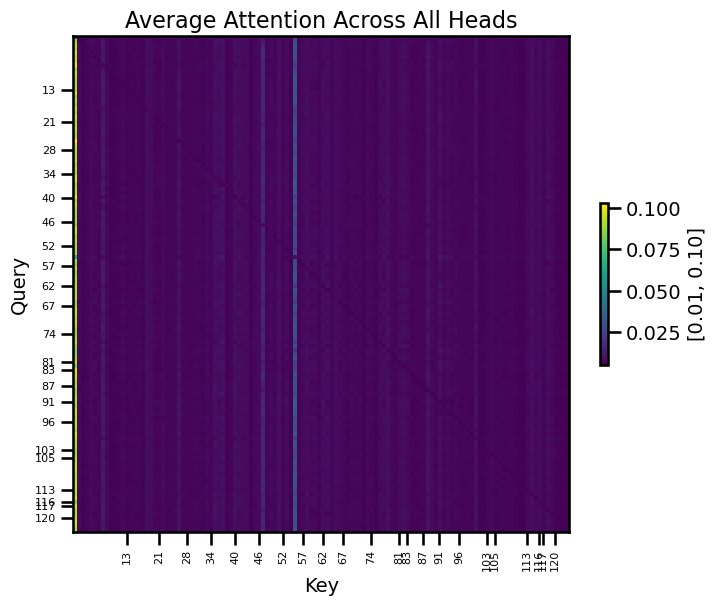


Genes in token 53:
['SFRP1', 'NKX6-3', 'ANK1', 'AP3M2', 'PLAT', 'IKBKB', 'SLC20A2', 'SMIM19', 'ASNSP1', 'SPIDR', 'SNTG1', 'RB1CC1', 'OPRK1', 'ATP6V1H', 'RGS20', 'LYPLA1', 'MRPL15', 'XKR4', 'TGS1', 'LYN', 'RPS20', 'CHCHD7', 'SDR16C5', 'PENK', 'SDCBP', 'NSMAF', 'TOX', 'CA8', 'CHD7', 'CLVS1', 'ASPH', 'NKAIN3', 'TTPA', 'MIR124-2HG', 'BHLHE22', 'CYP7B1', 'MTFR1', 'CRH', 'RRS1', 'C8orf46', 'MYBL1', 'C8orf44', 'PPP1R42', 'COPS5', 'PREX2', 'C8orf34', 'SULF1', 'LACTB2', 'XKR9', 'EYA1', 'KCNB2', 'RDH10', 'STAU2', 'UBE2W', 'ELOC', 'TMEM70', 'LY96', 'CRISPLD1', 'ZFHX4-AS1', 'ZFHX4']

Chromosome: NC_000008.11
SFRP1 NKX6-3 ANK1 AP3M2 PLAT IKBKB SLC20A2 SMIM19 ASNSP1 SPIDR SNTG1 RB1CC1 OPRK1 ATP6V1H RGS20 LYPLA1 MRPL15 XKR4 TGS1 LYN RPS20 CHCHD7 SDR16C5 PENK SDCBP NSMAF TOX CA8 CHD7 CLVS1 ASPH NKAIN3 TTPA MIR124-2HG BHLHE22 CYP7B1 MTFR1 CRH RRS1 C8orf46 MYBL1 C8orf44 PPP1R42 COPS5 PREX2 C8orf34 SULF1 LACTB2 XKR9 EYA1 KCNB2 RDH10 STAU2 UBE2W ELOC TMEM70 LY96 CRISPLD1 ZFHX4-AS1 ZFHX4
Note: Gene lists 

In [112]:
# Setup 
# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S400', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)]

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)
chrom_switches = chrom_switches[:-1]


def plot_attention_and_genes(attention_weights, chrom_switches, token_idx, is_cls_model=False, gene_tokens=gene_tokens):
    """
    Plot average attention head and print genes for specified token index
    
    Args:
        attention_weights: attention weight matrix
        chrom_switches: chromosome boundary indices
        token_idx: token index to analyze
        is_cls_model: whether attention is from CLS model
        gene_tokens: dictionary mapping token indices to gene information
    """
    # Plot average attention head
    print("Average Attention Head:")
    plot_average_head(attention_weights, chrom_switches)
    
    # Adjust token index for CLS model
    print_idx = token_idx - 1 if is_cls_model else token_idx
    
    print(f"\nGenes in token {print_idx}:")
    print(gene_tokens[print_idx]['genes'])
    print("\nChromosome:", gene_tokens[print_idx]['chromosome'])
    print(' '.join(gene_tokens[print_idx]['genes']))

# Example usage:
# For base model
plot_attention_and_genes(avg_base_smt_attn, chrom_switches, 106, is_cls_model=False)

# For CLS model  
plot_attention_and_genes(avg_smt_cls_attn, chrom_switches, 54, is_cls_model=True)

print("Note: Gene lists for any token can be manually passed into https://biit.cs.ut.ee/gprofiler/gost for quick functional profiling")
